In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, log_loss, mean_squared_error, accuracy_score, r2_score

from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

import joblib
from PyALE import ale
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier


In [9]:

# Load dataset
secondary_mushroom = fetch_ucirepo(id=848)
X = secondary_mushroom.data.features
y = secondary_mushroom.data.targets
df = pd.concat([X, y], axis=1)

Drop columns with >80% missing data:
stem-root, veil-type, veil-color, and spore-print-color have excessive missing values and are removed.

In [10]:
df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,...,y,w,u,w,t,g,NaN,d,w,p
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,...,y,w,u,w,t,g,NaN,d,u,p
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,...,y,w,u,w,t,g,NaN,d,w,p
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,...,y,w,u,w,t,p,NaN,d,w,p
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,...,y,w,u,w,t,p,NaN,d,w,p


handle the missing values

In [11]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


missing_values_table(df)

                   n_miss  ratio
veil-type           57892  94.80
spore-print-color   54715  89.60
veil-color          53656  87.86
stem-root           51538  84.39
stem-surface        38124  62.43
gill-spacing        25063  41.04
cap-surface         14120  23.12
gill-attachment      9884  16.18
ring-type            2471   4.05


In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=30):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [13]:
# Data Preprocessing
df = df.drop(columns=['stem-root', 'veil-type', 'veil-color', 'spore-print-color'])

cat_cols, num_cols, cat_but_car = grab_col_names(df)
cat_cols = [col for col in cat_cols if col not in ["class"]]
num_cols = [col for col in num_cols if col not in ["id"]]

Observations: 61069
Variables: 17
cat_cols: 14
num_cols: 3
cat_but_car: 0
num_but_cat: 0


In [14]:
from sklearn.impute import KNNImputer, SimpleImputer
def fill_missing_values(df, num_cols, cat_cols):
    
    # Create a copy of the original DataFrame to avoid modifying it
    filled_df = df.copy()
    
    # Fill missing values in numeric columns with median
    numeric_imputer = SimpleImputer(strategy='median')
    filled_df[num_cols] = numeric_imputer.fit_transform(filled_df[num_cols])

    # Fill missing values in categorical columns with mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    filled_df[cat_cols] = categorical_imputer.fit_transform(filled_df[cat_cols])

    return filled_df

df = fill_missing_values (df, num_cols, cat_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           61069 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       61069 non-null  object 
 6   gill-spacing          61069 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-surface          61069 non-null  object 
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

In [15]:
def fill_missing_values(df, num_cols, cat_cols):
    
    # Create a copy of the original DataFrame to avoid modifying it
    filled_df = df.copy()
    
    # Fill missing values in numeric columns with median
    numeric_imputer = SimpleImputer(strategy='median')
    filled_df[num_cols] = numeric_imputer.fit_transform(filled_df[num_cols])

    # Fill missing values in categorical columns with mode
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    filled_df[cat_cols] = categorical_imputer.fit_transform(filled_df[cat_cols])

    return filled_df

df = fill_missing_values (df, num_cols, cat_cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           61069 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       61069 non-null  object 
 6   gill-spacing          61069 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-surface          61069 non-null  object 
 11  stem-color            61069 non-null  object 
 12  has-ring              61069 non-null  object 
 13  ring-type             61069 non-null  object 
 14  habitat               61069 non-null  object 
 15  season             

### Encoding

In [16]:
unique_counts = df[cat_cols].nunique()
cat_cols_ohe = [col for col in cat_cols if unique_counts[col] < 5]
cat_cols_le = [col for col in cat_cols if unique_counts[col] >= 5]

In [17]:
label_encoders = {}
for col in cat_cols_le:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [18]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
df = one_hot_encoder(df, cat_cols_ohe)
df['class'] = le.fit_transform(df['class'])  
df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns})
df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,gill-attachment,gill-color,stem-height,stem-width,stem-surface,stem-color,ring-type,habitat,class,does-bruise-or-bleed_t,gill-spacing_d,gill-spacing_f,has-ring_t,season_s,season_u,season_w
0,15.26,6,2,6,2,10,16.95,17.09,7,11,2,0,1,0,0,0,1,0,0,1
1,16.60,6,2,6,2,10,17.99,18.19,7,11,2,0,1,0,0,0,1,0,1,0
2,14.07,6,2,6,2,10,17.80,17.74,7,11,2,0,1,0,0,0,1,0,0,1
3,14.17,2,3,1,2,10,15.77,15.98,7,11,5,0,1,0,0,0,1,0,0,1
4,14.64,6,3,6,2,10,16.53,17.20,7,11,5,0,1,0,0,0,1,0,0,1


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cap-diameter            61069 non-null  float64
 1   cap-shape               61069 non-null  int64  
 2   cap-surface             61069 non-null  int64  
 3   cap-color               61069 non-null  int64  
 4   gill-attachment         61069 non-null  int64  
 5   gill-color              61069 non-null  int64  
 6   stem-height             61069 non-null  float64
 7   stem-width              61069 non-null  float64
 8   stem-surface            61069 non-null  int64  
 9   stem-color              61069 non-null  int64  
 10  ring-type               61069 non-null  int64  
 11  habitat                 61069 non-null  int64  
 12  class                   61069 non-null  int64  
 13  does-bruise-or-bleed_t  61069 non-null  int64  
 14  gill-spacing_d          61069 non-null

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


# Preprocessing pipeline
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)


%pip install shap


models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'LDA': LinearDiscriminantAnalysis(),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=10, n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'MLP (Neural Network)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

In [20]:
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# One-hot encode categorical features
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features and target
X = df.drop(columns=['class'])
y = df['class'] # Assuming 'p' represents poisonous

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(y.value_counts())  # Ensure we have both classes


class
1    33888
0    27181
Name: count, dtype: int64


Feature: 0, Score: 0.04622
Feature: 1, Score: 0.04874
Feature: 2, Score: 0.08266
Feature: 3, Score: 0.03820
Feature: 4, Score: 0.09040
Feature: 5, Score: 0.08057
Feature: 6, Score: 0.10126
Feature: 7, Score: 0.15595
Feature: 8, Score: 0.07346
Feature: 9, Score: 0.07103
Feature: 10, Score: 0.05495
Feature: 11, Score: 0.03391
Feature: 12, Score: 0.03392
Feature: 13, Score: 0.06209
Feature: 14, Score: 0.00521
Feature: 15, Score: 0.01922
Feature: 16, Score: 0.00077
Feature: 17, Score: 0.00019
Feature: 18, Score: 0.00128


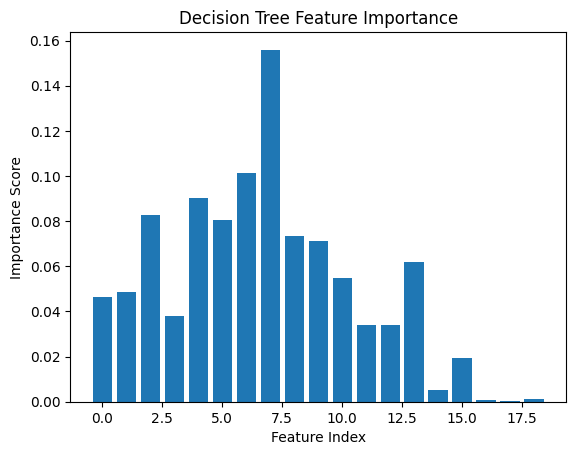

                   Feature  Importance
7               stem-width    0.155951
6              stem-height    0.101257
4          gill-attachment    0.090397
2              cap-surface    0.082660
5               gill-color    0.080565
8             stem-surface    0.073456
9               stem-color    0.071027
13          gill-spacing_d    0.062086
10               ring-type    0.054950
1                cap-shape    0.048745
0             cap-diameter    0.046218
3                cap-color    0.038196
12  does-bruise-or-bleed_t    0.033919
11                 habitat    0.033915
15              has-ring_t    0.019218
14          gill-spacing_f    0.005212
18                season_w    0.001277
16                season_s    0.000765
17                season_u    0.000187


In [21]:
# ALE plot
# fit training model
y_train = y_train.values.ravel()

# Fit the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

numerical_features = X_train.select_dtypes(include=['number']).columns

# feature importance with tree
# Get feature importances
importance = model.feature_importances_

# Print feature importances
for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')

# Plot feature importances
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Decision Tree Feature Importance")
plt.show()

# DataFrame with feature names and scores
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# sortted by importance descendingly
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(25))


In [22]:
# Tree model
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_features': ['sqrt', 'log2']
}
random_search = RandomizedSearchCV(model, param_grid, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5, 
                                   n_iter=10,
                                   verbose=1, 
                                   random_state=42, 
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters (Randomized Search):", random_search.best_params_)

# Best Model Evaluation
best_tree_random = random_search.best_estimator_
y_pred_random = best_tree_random.predict(X_test)
mse_random = mean_squared_error(y_test, y_pred_random)
print("Test MSE (Randomized Search):", mse_random)
r2 = r2_score(y_test, y_pred_random)
print("Test R^2:", r2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best Parameters (Randomized Search): {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Test MSE (Randomized Search): 0.05105422268805001
Test R^2: 0.7932876200892326


In [23]:
import statsmodels.api as sm
logit_model = sm.Logit(y_train, sm.add_constant(X_train))  
result = logit_model.fit()

y_train_pred_prob = result.predict(sm.add_constant(X_train))  
y_train_pred = (y_train_pred_prob > 0.5).astype(int)  

train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred_prob = result.predict(sm.add_constant(X_test))  
y_test_pred = (y_test_pred_prob > 0.5).astype(int)  

test_accuracy = accuracy_score(y_test, y_test_pred)
print("training:", train_accuracy)
print("testing:", test_accuracy)

Optimization terminated successfully.
         Current function value: 0.616782
         Iterations 6
training: 0.6508443352778631
testing: 0.6540854756836417


In [24]:
rf_classifier = RandomForestClassifier(n_estimators=80, random_state=42) 
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
#y_pred
accuracy = accuracy_score(y_test, y_pred)
accuracy
#(y_pred != y_test).sum()
report = classification_report(y_test, y_pred)
report 

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      5436\n           1       1.00      1.00      1.00      6778\n\n    accuracy                           1.00     12214\n   macro avg       1.00      1.00      1.00     12214\nweighted avg       1.00      1.00      1.00     12214\n'

In [32]:
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Dictionary to store model performance metrics
model_results = {}

# Function to train, evaluate, and optimize a model
def evaluate_model(model, name, param_grid=None):
    if param_grid:
        random_search = RandomizedSearchCV(model, param_grid, 
                                           scoring='accuracy', 
                                           cv=5, 
                                           n_iter=10,
                                           verbose=1, 
                                           random_state=42, 
                                           n_jobs=-1)
        random_search.fit(X_train_balanced, y_train_balanced)
        best_model = random_search.best_estimator_
        print(f"Best Parameters for {name}:", random_search.best_params_)
    else:
        best_model = model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    misclassification_rate = 1 - accuracy
    log_likelihood = -log_loss(y_test, y_proba)

    # Cross-validation
    cv_scores = cross_val_score(best_model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')

    model_results[name] = {
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc,
        "Misclassification Rate": misclassification_rate,
        "Log Likelihood": log_likelihood,
        "CV Accuracy Mean": cv_scores.mean(),
        "CV Accuracy Std": cv_scores.std()
    }

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous']))
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"Misclassification Rate: {misclassification_rate:.3f}")
    print(f"Log Likelihood: {log_likelihood:.3f}")
    print(f"CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}\n")

    return best_model

In [33]:
from sklearn.naive_bayes import GaussianNB

In [34]:
# Naive Bayes (Simple and interpretable)
nb_model = evaluate_model(GaussianNB(), "Naive Bayes")

# Logistic Regression (Easy to interpret coefficients)
lr_model = evaluate_model(LogisticRegression(max_iter=1000, class_weight='balanced'), "Logistic Regression")

# LDA (Assumes linear separation, interpretable)
lda_model = evaluate_model(LinearDiscriminantAnalysis(), "LDA")

# Random Forest (Interpretable with feature importance, includes hyperparameter tuning)
rf_params = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_features': ['sqrt', 'log2']
}
rf_model = evaluate_model(RandomForestClassifier(class_weight='balanced', random_state=42), "Random Forest", rf_params)


=== Naive Bayes ===
              precision    recall  f1-score   support

      Edible       0.62      0.57      0.59      5436
   Poisonous       0.67      0.72      0.69      6778

    accuracy                           0.65     12214
   macro avg       0.64      0.64      0.64     12214
weighted avg       0.65      0.65      0.65     12214

ROC-AUC: 0.703
Misclassification Rate: 0.350
Log Likelihood: -0.882
CV Accuracy: 0.641 ± 0.003


=== Logistic Regression ===
              precision    recall  f1-score   support

      Edible       0.62      0.65      0.63      5436
   Poisonous       0.71      0.68      0.69      6778

    accuracy                           0.66     12214
   macro avg       0.66      0.66      0.66     12214
weighted avg       0.67      0.66      0.66     12214

ROC-AUC: 0.714
Misclassification Rate: 0.337
Log Likelihood: -0.623
CV Accuracy: 0.663 ± 0.003


=== LDA ===
              precision    recall  f1-score   support

      Edible       0.62      0.65   


# SHAP Analysis for Feature Importance (Using Random Forest)
explainer = shap.Explainer(rf_model, X_train_balanced)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

In [35]:
# XGBoost with Hyperparameter Tuning
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}
xgb_model = evaluate_model(XGBClassifier(eval_metric='logloss', random_state=42), "XGBoost", xgb_params)

# KNN (Hyperparameter tuning for best 'k')
knn_params = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}
knn_model = evaluate_model(KNeighborsClassifier(), "KNN (k=5)", knn_params)



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for XGBoost: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}

=== XGBoost ===
              precision    recall  f1-score   support

      Edible       1.00      1.00      1.00      5436
   Poisonous       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC: 1.000
Misclassification Rate: 0.000
Log Likelihood: -0.006
CV Accuracy: 1.000 ± 0.000

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for KNN (k=5): {'weights': 'distance', 'n_neighbors': 3}

=== KNN (k=5) ===
              precision    recall  f1-score   support

      Edible       1.00      1.00      1.00      5436
   Poisonous       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC-AUC: 1.000
Misclassification Rate: 0.001
Log Likelihood: -0.007
CV Accuracy: 0.999 ± 0.000



In [40]:
# Define MLP parameters (simplified to reduce computation)
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],  # Different network sizes
    'activation': ['relu', 'tanh'],  # Different activation functions
    'max_iter': [300, 500]  # Different training iterations
}

# Train MLP model with optimized settings
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42, early_stopping=True)

# Fit the model on training data
mlp_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = mlp_model.predict(X_test)
y_proba = mlp_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
misclassification_rate = 1 - accuracy
log_likelihood = -log_loss(y_test, y_proba)

# Print Metrics in Comparable Format
print("\n=== MLP Neural Network ===")
print(classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous']))
print(f"Log Likelihood: {log_likelihood:.3f}")

model_results["MLP Neural Network"] = {
        "Accuracy": accuracy,
        "ROC-AUC": roc_auc,
        "Misclassification Rate": misclassification_rate,
        "Log Likelihood": log_likelihood
    }


=== MLP Neural Network ===
              precision    recall  f1-score   support

      Edible       1.00      1.00      1.00      5436
   Poisonous       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

Log Likelihood: -0.008


# result without cv

In [43]:
# Initialize models
models = {
    'Naive Bayes': CategoricalNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'LDA': LinearDiscriminantAnalysis(),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42, max_depth=10, n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'MLP (Neural Network)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Classification Report & ROC-AUC
    report = classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous'])
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    accuracy = accuracy_score(y_test, y_pred)
    misclassification_rate = 1 - accuracy 
    # Compute log-likelihood
    log_likelihood = -log_loss(y_test, model.predict_proba(X_test))

    # Compute null log-likelihood (baseline model using majority class probability)
    y_null = np.full_like(y_test, y_test.value_counts().idxmax())  # Predict the majority class
    log_likelihood_null = -log_loss(y_test, np.full((len(y_test), 2), y_test.mean())) 

    
    results[name] = {
        'report': report,
        'roc_auc': roc_auc,
        'misclassification_rate': misclassification_rate
    }

# Print results
for name, metrics in results.items():
    print(f"=== {name} ===")
    print(metrics['report'])
    print(f"ROC-AUC: {metrics['roc_auc']:.3f}")
    print(f"Misclassification Rate: {metrics['misclassification_rate']:.3f}\n")


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:59:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/site-packages/

=== Naive Bayes ===
              precision    recall  f1-score   support

      Edible       0.70      0.76      0.73      5436
   Poisonous       0.79      0.74      0.76      6778

    accuracy                           0.75     12214
   macro avg       0.75      0.75      0.75     12214
weighted avg       0.75      0.75      0.75     12214

ROC-AUC: 0.838
Misclassification Rate: 0.253

=== Logistic Regression ===
              precision    recall  f1-score   support

      Edible       0.62      0.64      0.63      5436
   Poisonous       0.70      0.68      0.69      6778

    accuracy                           0.66     12214
   macro avg       0.66      0.66      0.66     12214
weighted avg       0.66      0.66      0.66     12214

ROC-AUC: 0.714
Misclassification Rate: 0.337

=== LDA ===
              precision    recall  f1-score   support

      Edible       0.64      0.50      0.56      5436
   Poisonous       0.66      0.78      0.71      6778

    accuracy                  

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [44]:
# Convert results to DataFrame and save to CSV
df_results = pd.DataFrame.from_dict(model_results, orient='index')
csv_filename = "model_comparison_results.csv"
df_results
# Save the CSV file
df_results.to_csv(csv_filename, index=True)

/var/folders/mz/m3d6qq5179360gl20vnsvxch0000gn/T/ipykernel_89663/3051379102.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(df_results.index, rotation=45)
/var/folders/mz/m3d6qq5179360gl20vnsvxch0000gn/T/ipykernel_89663/3051379102.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(df_results.index, rotation=45)


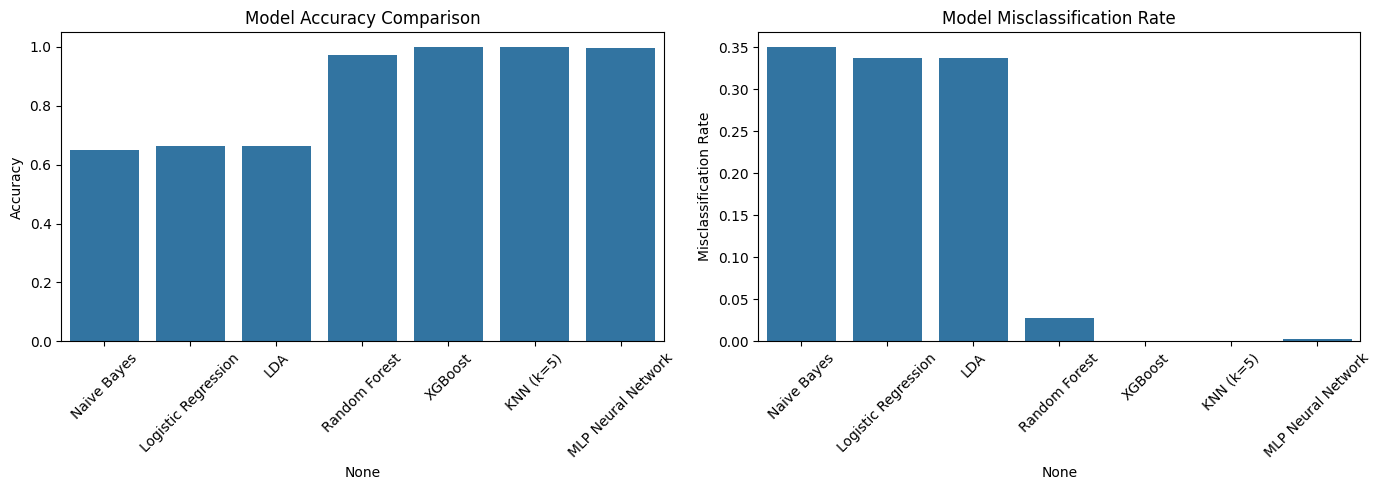

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load results
df_results = pd.read_csv("model_comparison_results.csv", index_col=0)

# Plot accuracy and misclassification rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=df_results.index, y=df_results["Accuracy"], ax=axes[0])
axes[0].set_title("Model Accuracy Comparison")
axes[0].set_xticklabels(df_results.index, rotation=45)

sns.barplot(x=df_results.index, y=df_results["Misclassification Rate"], ax=axes[1])
axes[1].set_title("Model Misclassification Rate")
axes[1].set_xticklabels(df_results.index, rotation=45)

plt.tight_layout()
plt.show()


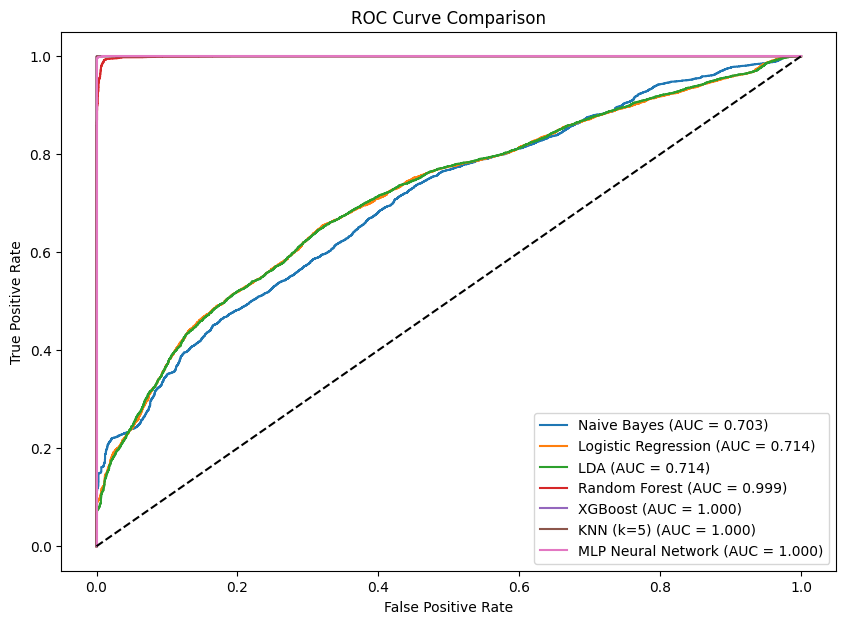

In [47]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

models = {
    "Naive Bayes": nb_model,
    "Logistic Regression": lr_model,
    "LDA": lda_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "KNN (k=5)": knn_model,
    "MLP Neural Network": mlp_model
}

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()
